# BalancedRandomForestClassifier
### Использование алгоритма спициально разработанного для классификации в условиях высокого дисбаланса классов
Используются все признаки


In [28]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
import Handlers as hd

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from category_encoders.one_hot import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline

from imblearn.ensemble import BalancedRandomForestClassifier
import optuna

from sklearn import set_config
set_config(transform_output = 'pandas')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_palette('Set2')

# Загрузка данных
используется файл обработанных данных, в котором:
- удален начальный, нерелевантный, период
- обработаны пропуски
- произведена трансформация признаков
- сгенерированны новые признаки

### Загружаю все обработанные и созданные признаки

In [30]:
TARGET = "Long"

df = pd.read_parquet(
    "../data/ETH-Full-1H_prepared.parquet",
    columns=[
        "Open_log_return",
        "High_log_return",
        "Low_log_return",
        "Close_log_return",
        "Volume_log",
        "Trades_log",
        "up_move",
        "down_move",
        "up_shadow",
        "down_shadow",
        "Month",
        "Day_of_Week",
        "Hour",
        "SMA_6h_diff",
        "SMA_5d_diff",
        "SMA_30d_diff",
        "rsi_14",
        TARGET,
    ],
)
df = df.asfreq("H")  # установка периода для timeseries

### Оценка корреляции

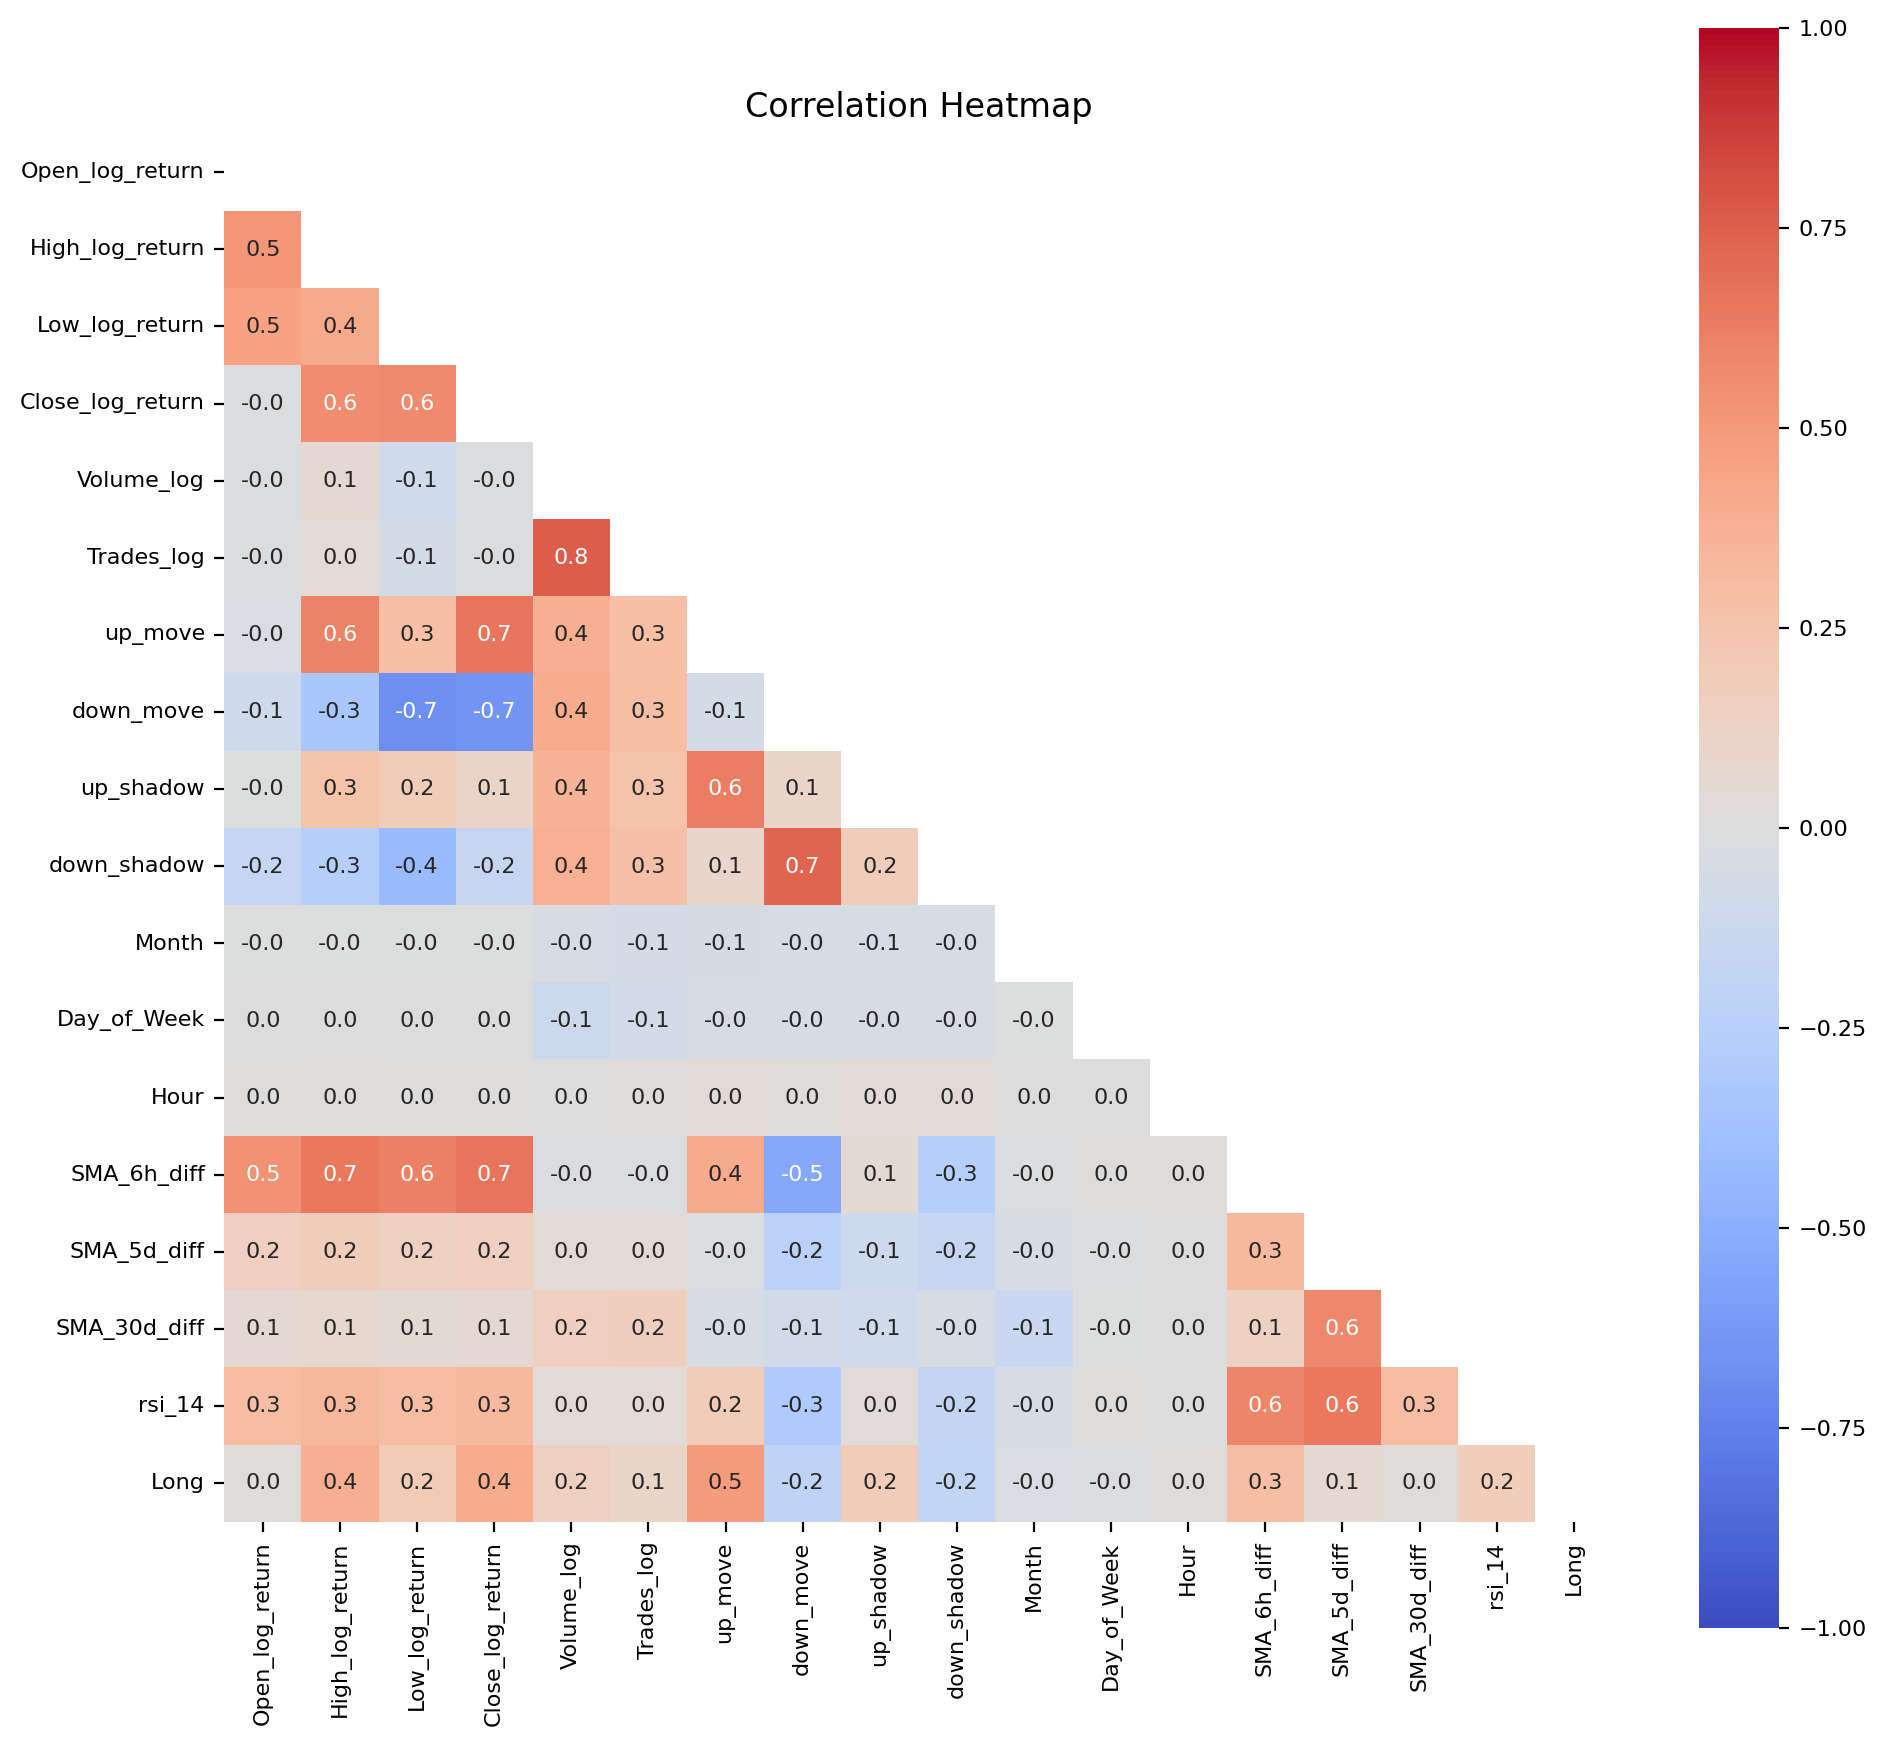

In [31]:
hd.plot_corr_heatmap(df, 1)

- Избавляюсь от мультиколинеарности. 
- Удаляю наиболее сильно коррелированные признаки.
- Между Volume_log и Trades_log по сути связь ближе к чистой коллинераности, признаки свзязаны линейно через цену.

In [32]:
df.drop(columns=["Volume_log", "down_move"], inplace=True)

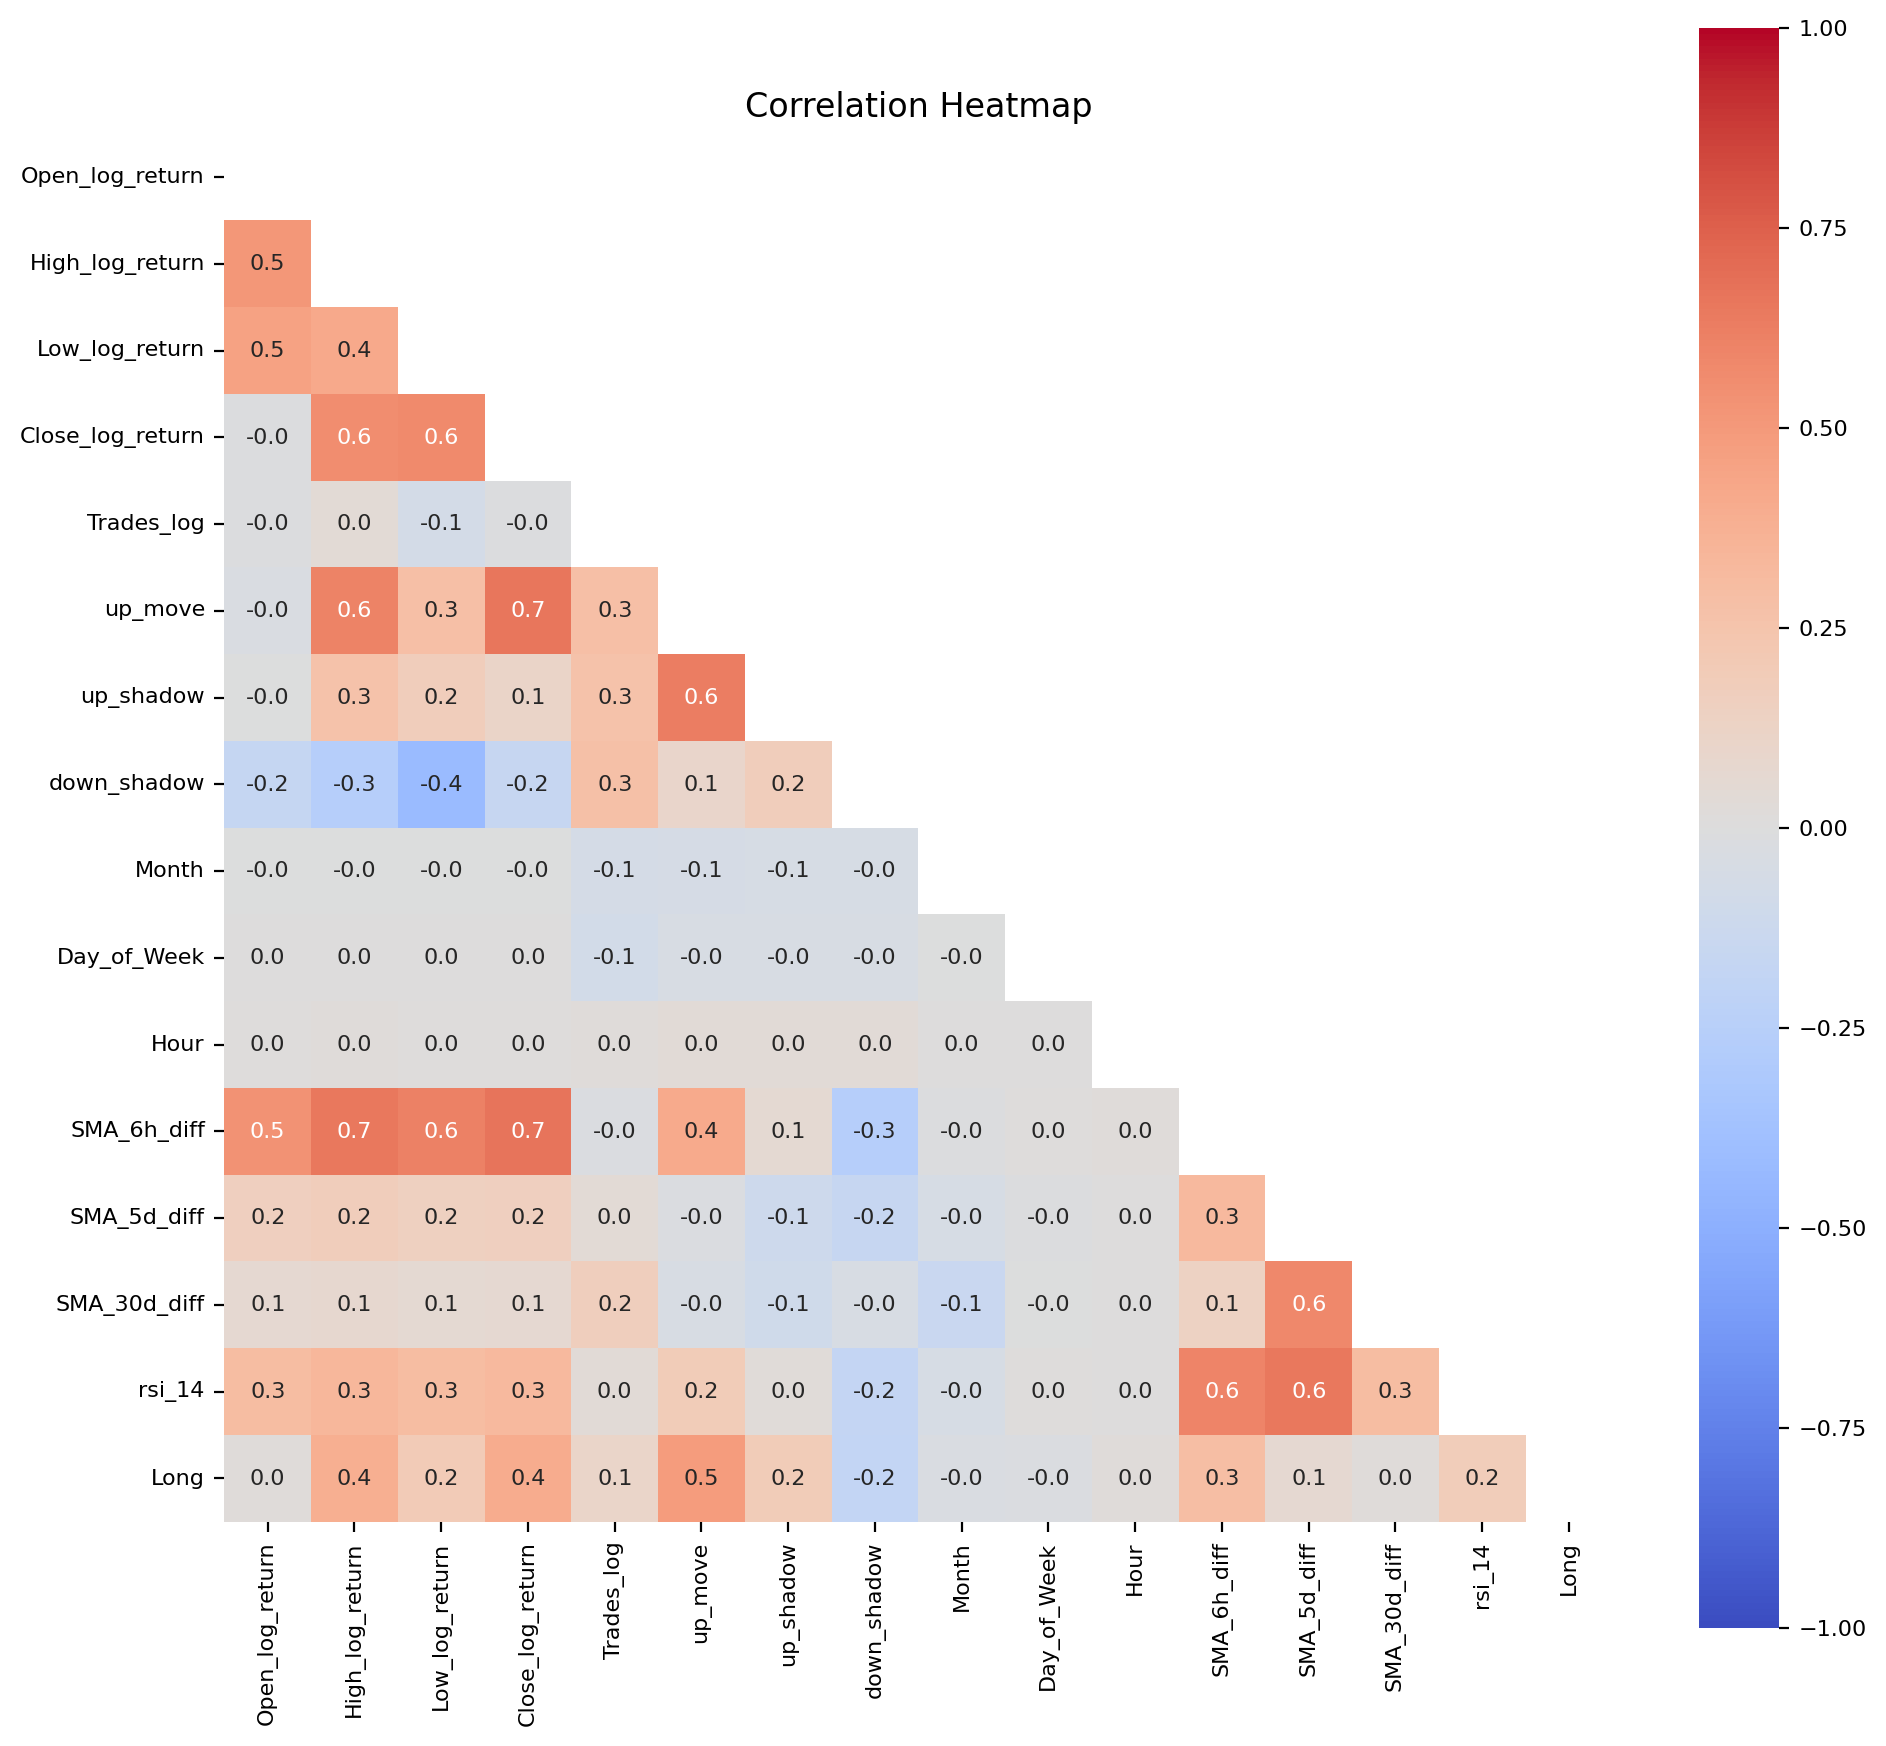

In [33]:
hd.plot_corr_heatmap(df, 1)

# Кодирование категориальных признаков 
- "Month", "Day_of_Week", "Hour" считаю категориальными номинальными признаками, кодирую как OneHot
- Так же данным признакам не нужна глубина, достаточно значения на последнем баре. Т.к. эти признаки линейно связаны на временном ряду.

In [34]:
cat_time_features = ["Month", "Day_of_Week", "Hour"]

In [35]:
# отдельный датафрейм для обработки признаков по которым не нужна глубина
df_cat_time = df[cat_time_features + [TARGET]].copy()

# из исходного датафрейма удаляю принаки без глубины
df.drop(columns=cat_time_features, inplace=True)

ohe = OneHotEncoder(cols=["Month", "Day_of_Week", "Hour"])
df_cat_time = ohe.fit_transform(df_cat_time)

# Transform TimeSeries to Dataset for Supervised Learning
Определяется глубина последовательности данных T, которая будет использоваться для построения прогноза. Временное окно в прошлое.

In [36]:
T = 6

Create $X$, $y$

In [37]:
X, y, N, D = hd.create_X_y_from_timeseries(df, TARGET, T)

In [38]:
print("X.shape:", X.shape, "y.shape:", y.shape, "N:", N, "D:", D)

X.shape: (45114, 72) y.shape: (45114,) N: 45114 D: 12


Преобразование временных признаков без глубины, где не нужна последовательность, а всего лишь значение на последнем баре. Задаю T=1.

In [39]:
X_t, _, _, _ = hd.create_X_y_from_timeseries(df_cat_time, TARGET, 1)

In [40]:
print('X.shape:', X_t.shape)

X.shape: (45119, 43)


Выправляю длину, объединяю признаки

In [41]:
# сокращаю спарава до длины основного датасета X
X_t = X_t[-N:,]

# объединаю датасеты с признаками
X = np.concatenate((X, X_t), axis=1)
X.shape

(45114, 115)

# Split Data
Разбиение со стратифиацией

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.3
)

### BalancedRandomForestClassifier
С гиперпараметрами по умолчанию

In [44]:
model = BalancedRandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.681
Precision: 0.221
Recall: 1.000
F1: 0.361
ROC AUC: 0.825

*** TEST ***
Accuracy: 0.541
Precision: 0.123
Recall: 0.665
F1: 0.207
ROC AUC: 0.597


Вариант со взвешиванием классов

In [45]:
model = BalancedRandomForestClassifier(class_weight="balanced", random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.796
Precision: 0.307
Recall: 1.000
F1: 0.470
ROC AUC: 0.888

*** TEST ***
Accuracy: 0.669
Precision: 0.114
Recall: 0.395
F1: 0.177
ROC AUC: 0.546


Без контроля гиперпараметров идет тотальное переобучение

In [46]:
pipe = Pipeline(
    [
        ("scaler", hd.SelectScaler()),
        (
            "classifier",
            BalancedRandomForestClassifier(random_state=42),
        ),
    ]
)

### Использование Optuna для подбора гиперпараметров

In [50]:
def objective(trial, pipeline, X, y, n_splits=5, random_state=42, scoring_metric="f1"):
    params = {
        "scaler__name": trial.suggest_categorical(
            "scaler__name",
            ["standard", "minmax", "robust", "mean_normalization", "no_scaler"],
        ),
        "classifier__n_estimators": trial.suggest_int(
            "classifier__n_estimators", 10, 500, 5
        ),
        "classifier__max_depth": trial.suggest_int("classifier__max_depth", 1, 40),
        "classifier__min_samples_split": trial.suggest_int(
            "classifier__min_samples_split", 2, 20
        ),
        "classifier__min_samples_leaf": trial.suggest_int(
            "classifier__min_samples_leaf", 1, 10
        ),
        "classifier__criterion": trial.suggest_categorical(
            "classifier__criterion", ["gini", "entropy"]
        ),
    }
    pipeline.set_params(**params)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv_metrics = cross_validate(
        estimator=pipeline,
        X=X,
        y=y,
        cv=skf,
        scoring=scoring_metric,
        n_jobs=-1,
        return_train_score=False,
    )
    score = np.mean(cv_metrics["test_score"])

    return score

In [51]:
%%time
study = optuna.create_study(study_name='BRFC', direction="maximize")
study.optimize(lambda trial: objective(trial, pipe, X_train, y_train), n_trials=15)

print('Best f1 value:', study.best_value)
print('Best params:', study.best_params)

[I 2023-09-06 16:22:45,164] A new study created in memory with name: BRFC
[I 2023-09-06 16:22:55,450] Trial 0 finished with value: 0.20286404204652292 and parameters: {'scaler__name': 'standard', 'classifier__n_estimators': 315, 'classifier__max_depth': 2, 'classifier__min_samples_split': 11, 'classifier__min_samples_leaf': 8, 'classifier__criterion': 'gini'}. Best is trial 0 with value: 0.20286404204652292.
[I 2023-09-06 16:23:09,366] Trial 1 finished with value: 0.2046399046472649 and parameters: {'scaler__name': 'no_scaler', 'classifier__n_estimators': 315, 'classifier__max_depth': 4, 'classifier__min_samples_split': 11, 'classifier__min_samples_leaf': 9, 'classifier__criterion': 'gini'}. Best is trial 1 with value: 0.2046399046472649.
[I 2023-09-06 16:23:54,182] Trial 2 finished with value: 0.20483131619046174 and parameters: {'scaler__name': 'no_scaler', 'classifier__n_estimators': 430, 'classifier__max_depth': 38, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf

Best f1 value: 0.20606944179585515
Best params: {'scaler__name': 'mean_normalization', 'classifier__n_estimators': 125, 'classifier__max_depth': 8, 'classifier__min_samples_split': 13, 'classifier__min_samples_leaf': 9, 'classifier__criterion': 'gini'}
CPU times: total: 984 ms
Wall time: 5min 59s


In [57]:
study.optimize(lambda trial: objective(trial, pipe, X_train, y_train), n_trials=30)
print('Best f1 value:', study.best_value)
print('Best params:', study.best_params)

[I 2023-09-06 16:48:10,733] Trial 45 finished with value: 0.20504936443404675 and parameters: {'scaler__name': 'robust', 'classifier__n_estimators': 420, 'classifier__max_depth': 10, 'classifier__min_samples_split': 12, 'classifier__min_samples_leaf': 6, 'classifier__criterion': 'gini'}. Best is trial 32 with value: 0.20696681107991663.
[I 2023-09-06 16:48:28,315] Trial 46 finished with value: 0.20540673450906038 and parameters: {'scaler__name': 'standard', 'classifier__n_estimators': 460, 'classifier__max_depth': 4, 'classifier__min_samples_split': 19, 'classifier__min_samples_leaf': 3, 'classifier__criterion': 'gini'}. Best is trial 32 with value: 0.20696681107991663.
[I 2023-09-06 16:49:00,378] Trial 47 finished with value: 0.20478030272190217 and parameters: {'scaler__name': 'robust', 'classifier__n_estimators': 480, 'classifier__max_depth': 9, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__criterion': 'gini'}. Best is trial 32 with value: 0.206

Best f1 value: 0.20766161168105887
Best params: {'scaler__name': 'no_scaler', 'classifier__n_estimators': 440, 'classifier__max_depth': 12, 'classifier__min_samples_split': 13, 'classifier__min_samples_leaf': 6, 'classifier__criterion': 'gini'}


In [61]:
best_params = study.best_params
best_params

{'scaler__name': 'no_scaler',
 'classifier__n_estimators': 440,
 'classifier__max_depth': 12,
 'classifier__min_samples_split': 13,
 'classifier__min_samples_leaf': 6,
 'classifier__criterion': 'gini'}

In [62]:
pipe.set_params(**best_params)

Pipeline(steps=[('scaler', SelectScaler()),
                ('classifier',
                 BalancedRandomForestClassifier(max_depth=12,
                                                min_samples_leaf=6,
                                                min_samples_split=13,
                                                n_estimators=440,
                                                random_state=42))])

In [63]:
pipe.fit(X_train, y_train)
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.572
Precision: 0.166
Recall: 0.925
F1: 0.281
ROC AUC: 0.731

*** TEST ***
Accuracy: 0.520
Precision: 0.126
Recall: 0.725
F1: 0.214
ROC AUC: 0.612


Применение данной модели не дало улучшений метрик, а вот разброс вырос.